##Preparation
(Install, Import Library, Check Dataset)

In [ ]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import tensorflow

import numpy as np # linear algebra
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import KFold
import random
import sys
import pandas
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
import gc

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB2

In [ ]:
# Check dataset
from google.colab import drive
drive.mount ('/content/drive')

base_dir = '/content/drive/MyDrive/data/COVID_Multiclass_CT_Scan/New_Data_CoV2'
ct_scans = os.listdir(base_dir)
ct_scans

Mounted at /content/drive


['Others', 'Healthy', 'Covid']

In [ ]:
# Total dataset
total = 0

for i in ct_scans:
    dir = os.path.join(base_dir, i)
    num = len(os.listdir(dir))
    print(i+':', num, 'data')
    total = total + num

print('__________________________________')
print('\nTotal:', total, 'data')

Others: 1247 data
Healthy: 757 data
Covid: 2168 data
__________________________________

Total: 4172 data


## Pre-Processing

In [ ]:
!pip install split-folders

In [ ]:
# Split folder to divide the dataset into training, validation, and testing data
import splitfolders
splitfolders.ratio(base_dir, output="./train-test", seed=42, ratio=(.80, 0.1, 0.1))

Copying files: 4172 files [01:17, 53.72 files/s] 


In [ ]:
# dataset directory
train_dir = 'train-test/train'
val_dir = 'train-test/val'
test_dir = 'train-test/test'

##Data Augmentation (Pre-processing)

In [ ]:
# Hyperparameter Initiation
input_tensor  = Input(shape=(224,224,3))
learning_rate = 0.0001
epochs        = 60
image_size    = (224, 224)
batch_size    = 16

# Data augmentation on training data
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=15,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip = True,
                    fill_mode='nearest')

# Rescale on validation data
val_datagen = ImageDataGenerator(rescale=1./255)

#flow_from_directory() method takes a path of a directory and generates
# batches of augmented data.

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=image_size,
                    batch_size=batch_size,
                    shuffle=True,
                    class_mode='categorical',
                    #subset='training'
)

validation_generator = val_datagen.flow_from_directory(
                    val_dir,
                    target_size=image_size,
                    batch_size=batch_size,
                    shuffle=False,
                    class_mode='categorical',
                    #subset='validation'
)

Found 3336 images belonging to 3 classes.
Found 415 images belonging to 3 classes.


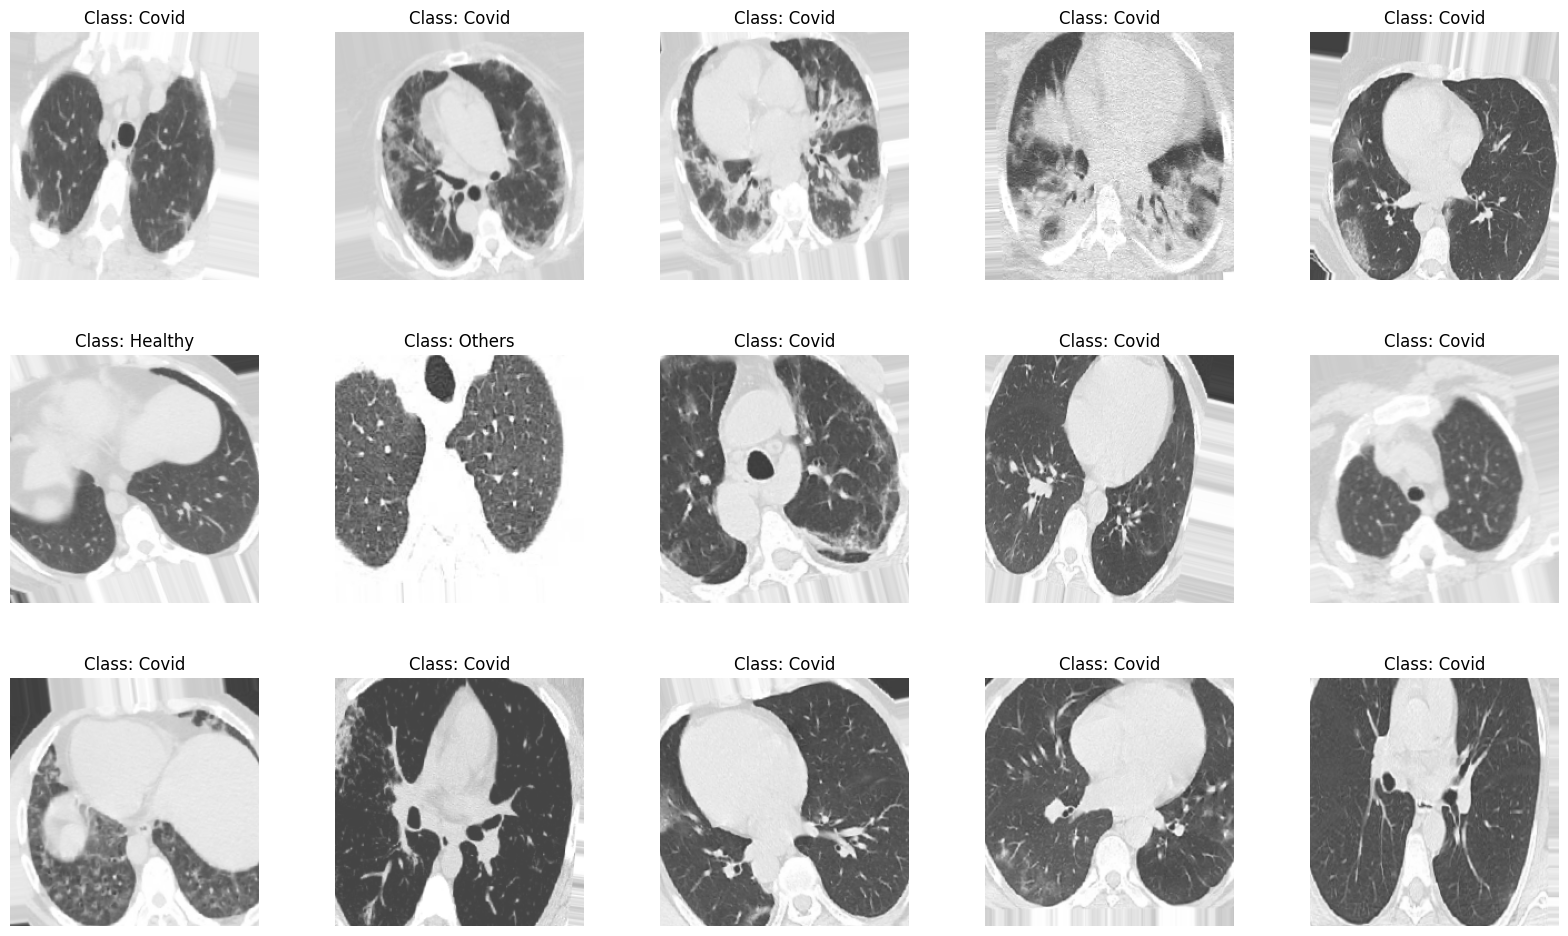

In [ ]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

## Building Models with CNN (Convolutional Neural Network)

In [ ]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras import layers, Model, Input

def getModel():
        base_model = EfficientNetB2(input_shape=(256, 256, 3),include_top=False, input_tensor=input_tensor)
        base_model = base_model.output
        model = GlobalAveragePooling2D()(base_model)
        model = Dense(256, activation='relu')(model)
        model = Dropout(0.2)(model)
        model = BatchNormalization()(model)
        model = Dense(3, activation='softmax')(model)
        model = Model(inputs=input_tensor, outputs=model)

        for layer in model.layers:
            layer.trainable = True

            model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

        return model

model=getModel()

31790344/31790344 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

##Callbacks

In [ ]:
# Save output model
model_file_path='./efficientnet_model.hdf5'

# This callback will stop the training when there is no improvement in
# the val_loss for 20 consecutive epochs
early_stop = EarlyStopping(patience=20,
                          verbose=1,
                          mode='auto')

# Reduce learning rate when a metric has stopped improving.
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=10,
                                  verbose=1,factor=0.2, min_lr=0.000001)

# save the best model (best Validation Accuracy)
checkpoints = ModelCheckpoint(model_file_path,monitor='val_accuracy',
                                  mode='max',save_best_only=True)

##Model Training

In [ ]:
model=getModel()

# fit model
steps_per_epoch=train_generator.n/batch_size
validation_steps=validation_generator.n/batch_size

history = model.fit(
              train_generator,
              steps_per_epoch=steps_per_epoch,  # how many batches will be executed in each epoch
              epochs=epochs,
              validation_data=validation_generator, # displays the accuracy of validation data testing
              validation_steps=validation_steps,  # how many batches will be executed in each epoch
              callbacks=[early_stop,learn_control,checkpoints],
              verbose=1)

Epoch 1/60
209/208 [==============================] - ETA: 0s - loss: 1.0631 - accuracy: 0.5656

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


208/208 [==============================] - 147s 393ms/step - loss: 1.0631 - accuracy: 0.5656 - val_loss: 1.0110 - val_accuracy: 0.4988 - lr: 1.0000e-04
Epoch 2/60
208/208 [==============================] - 81s 386ms/step - loss: 0.7413 - accuracy: 0.7110 - val_loss: 1.0002 - val_accuracy: 0.5181 - lr: 1.0000e-04
Epoch 3/60
208/208 [==============================] - 77s 367ms/step - loss: 0.5897 - accuracy: 0.7698 - val_loss: 1.0444 - val_accuracy: 0.5060 - lr: 1.0000e-04
Epoch 4/60
208/208 [==============================] - 77s 367ms/step - loss: 0.5046 - accuracy: 0.8097 - val_loss: 1.0766 - val_accuracy: 0.4988 - lr: 1.0000e-04
Epoch 5/60
208/208 [==============================] - 77s 370ms/step - loss: 0.4331 - accuracy: 0.8372 - val_loss: 1.2175 - val_accuracy: 0.3229 - lr: 1.0000e-04
Epoch 6/60
208/208 [==============================] - 78s 374ms/step - loss: 0.3692 - accuracy: 0.8552 - val_loss: 0.8704 - val_accuracy: 0.6289 - lr: 1.0000e-04
Epoch 7/60
208/208 [==================

##Model Evaluation

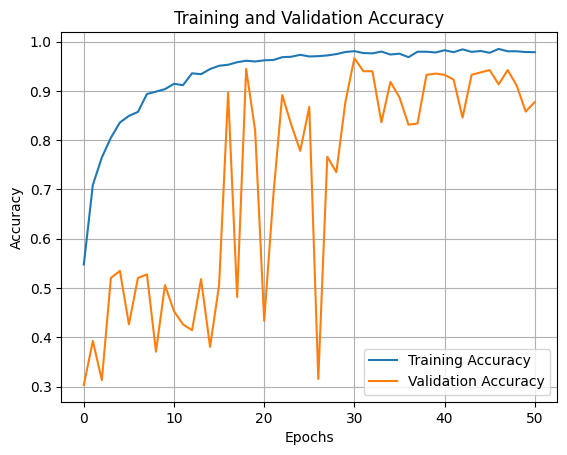

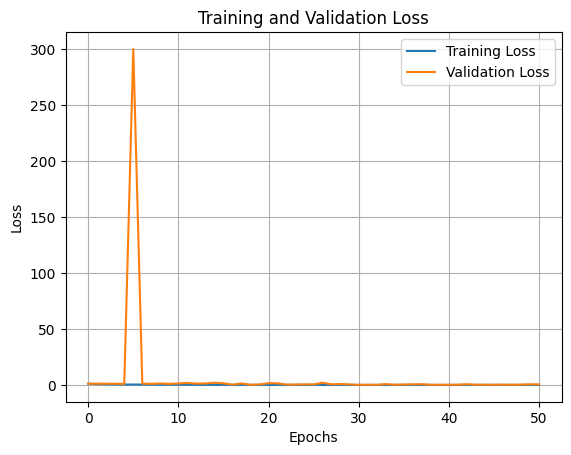

In [ ]:
# Plot Model Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Model Loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.plot(epochs, loss_train,  label='Training Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix and Classification Report

26/26 [==============================] - 2s 86ms/step - loss: 0.1035 - accuracy: 0.9663
Train Accuracy: 98.53%
Validation Accuracy: 96.63%
25/25 [==============================] - 5s 126ms/step


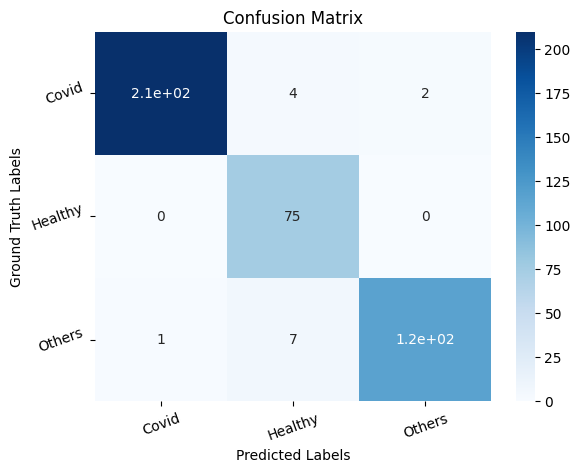

<Figure size 300x300 with 0 Axes>


              ---Classification Report---

              precision    recall  f1-score   support

       Covid     0.9953    0.9722    0.9836       216
     Healthy     0.8721    1.0000    0.9317        75
      Others     0.9831    0.9355    0.9587       124

    accuracy                         0.9663       415
   macro avg     0.9501    0.9692    0.9580       415
weighted avg     0.9694    0.9663    0.9668       415



In [ ]:
#Load model
model.load_weights(model_file_path)
validation_generator.reset()

# Model evaluation
scores_train = model.evaluate(train_generator,verbose=1)
scores_validation = model.evaluate(validation_generator, verbose=1)
print("Train Accuracy: %.2f%%" % (scores_train[1]*100))
print("Validation Accuracy: %.2f%%" % (scores_validation[1]*100))

# Model Prediction
pred=model.predict(validation_generator, steps=validation_steps, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

actual_class = validation_generator.classes
actual = [labels[k] for k in actual_class]
val_labels = [fn.split('/')[0] for fn in actual]

target_names=list(validation_generator.class_indices.keys())

# Confusion Matrix
cm=confusion_matrix(val_labels, predictions)

# Confusion Matrix Figure
fig = sns.heatmap(cm, annot=True, cmap = "Blues")
fig.set(title = 'Confusion Matrix', xlabel='Predicted Labels', ylabel='Ground Truth Labels')
fig.set_xticklabels(target_names,rotation=20)
fig.set_yticklabels(target_names,rotation=20)
plt.figure(figsize=(3,3))
plt.show(fig)

# Classification Report
cr=classification_report(val_labels, predictions, digits=4)
print("\n              ---Classification Report---\n")
print(cr)

##Testing Model

Found 420 images belonging to 3 classes.
26/26 [==============================] - 5s 138ms/step
[[207   8   2]
 [  0  74   3]
 [  2  10 114]]


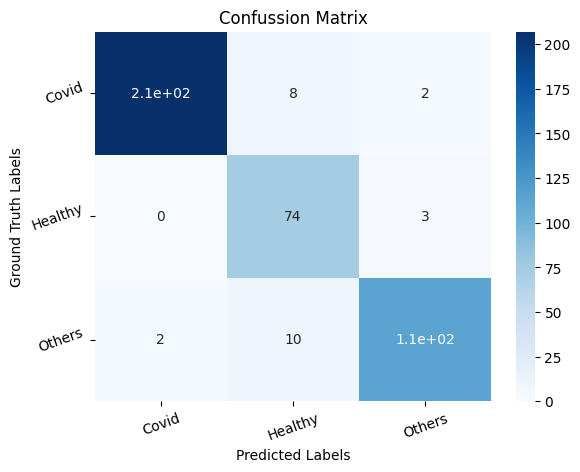

<Figure size 300x300 with 0 Axes>


              ---Classification Report---

              precision    recall  f1-score   support

       Covid     0.9904    0.9539    0.9718       217
     Healthy     0.8043    0.9610    0.8757        77
      Others     0.9580    0.9048    0.9306       126

    accuracy                         0.9405       420
   macro avg     0.9176    0.9399    0.9261       420
weighted avg     0.9466    0.9405    0.9418       420



In [ ]:
# Rescale
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size=image_size,
                 batch_size=batch_size,
                 class_mode=None,
                 shuffle=False)
test_steps=test_generator.n/batch_size
test_generator.reset()

#Calling the saved model for making predictions
model_file='./efficientnet_model.hdf5'
tl_img_aug_cnn = load_model(model_file)
pred=tl_img_aug_cnn.predict(test_generator,
                            verbose=1,
                            steps=test_steps)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results_test.csv",index=False)
target_names=list(validation_generator.class_indices.keys())
test_labels = [fn.split('/')[0] for fn in filenames]
cm=confusion_matrix(test_labels,predictions)
print(cm)


#Confussion Matrix Figure
fig = sns.heatmap(cm, annot=True, cmap = "Blues")
fig.set(title = 'Confussion Matrix', xlabel='Predicted Labels', ylabel='Ground Truth Labels')
fig.set_xticklabels(target_names,rotation=20)
fig.set_yticklabels(target_names,rotation=20)
plt.figure(figsize=(3,3))
plt.show(fig)

#Classification Report
cr=classification_report(test_labels, predictions, digits=4)
print("\n              ---Classification Report---\n")
print(cr)

In [ ]:
!zip -r /content/train-test.zip /content/train-test

  adding: content/train-test/ (stored 0%)
  adding: content/train-test/test/ (stored 0%)
  adding: content/train-test/test/Healthy/ (stored 0%)
  adding: content/train-test/test/Healthy/Healthy (594).png (deflated 1%)
  adding: content/train-test/test/Healthy/Healthy (642).png (deflated 1%)
  adding: content/train-test/test/Healthy/Healthy (685).png (deflated 0%)
  adding: content/train-test/test/Healthy/Healthy (128).png (deflated 1%)
  adding: content/train-test/test/Healthy/Healthy (601).png (deflated 1%)
  adding: content/train-test/test/Healthy/Healthy (313).png (deflated 0%)
  adding: content/train-test/test/Healthy/Healthy (90).png (deflated 1%)
  adding: content/train-test/test/Healthy/Healthy (440).png (deflated 1%)
  adding: content/train-test/test/Healthy/Healthy (342).png (deflated 0%)
  adding: content/train-test/test/Healthy/Healthy (432).png (deflated 1%)
  adding: content/train-test/test/Healthy/Healthy (139).png (deflated 0%)
  adding: content/train-test/test/Healthy/H

1/1 [==============================] - 0s 29ms/step
Prediksi: Covid


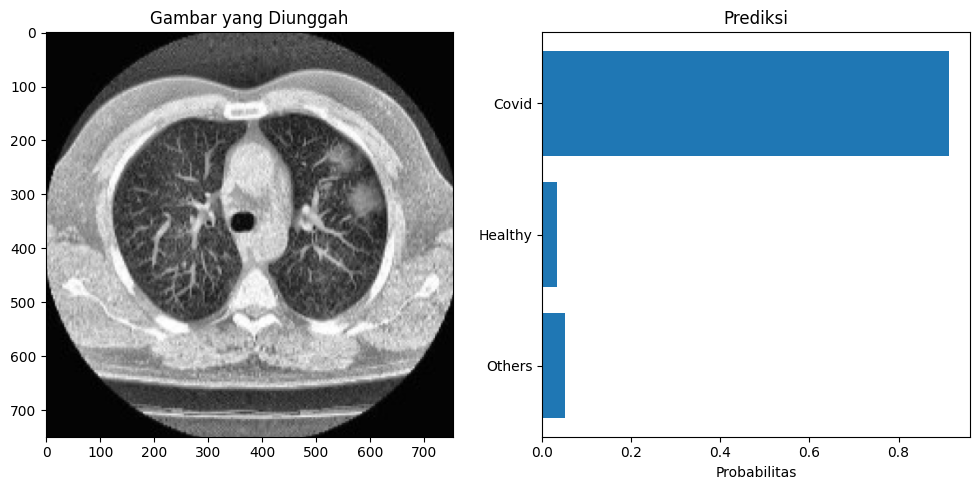

In [ ]:
from keras.preprocessing import image
from PIL import Image
import numpy as np

# Mengganti 'file.png' dengan nama gambar yang diunggah oleh pengguna
image_path = '/content/drive/MyDrive/data/COVID_Multiclass_CT_Scan/Penyakit_apa_ini.png'

# Memuat gambar menggunakan PIL dan mengubah ukurannya menjadi (224, 224)
img = Image.open(image_path)
img = img.resize((224, 224))

# Mengubah gambar menjadi array numpy
img = np.array(img)
img = img[:, :, :3]  # Menghilangkan saluran ke-4 (channel-4)
img = img / 255.0  # Normalisasi gambar
img = np.expand_dims(img, axis=0)  # Menambahkan dimensi batch

# Melakukan prediksi dengan model
prediction = model.predict(img)

# Mendapatkan kategori yang paling mungkin
predicted_category = np.argmax(prediction)

# Anda dapat mengganti kategori dengan label yang sesuai dengan model Anda
labels = ['Others', 'Healthy', 'Covid']  # Ganti dengan label-label Anda

predicted_label = labels[predicted_category]
print(f'Prediksi: {predicted_label}')

# Menampilkan gambar dan prediksi di sebelah kanan gambar
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.array(Image.open(image_path)))
plt.title('Gambar yang Diunggah')

plt.subplot(1, 2, 2)
plt.barh(labels, prediction[0])
plt.xlabel('Probabilitas')
plt.title('Prediksi')

plt.tight_layout()
plt.show()
